# Notebook #1: Queries, Visualización y Análisis

- En este notebook realizaremos consultas sobre nuestra base de datos y las usaremos para analizar nuestros datos, generarando visualizaciones que nos permitan entender mejor lo que sucede.

- El primer paso será importar las librerías necesarias:

In [475]:
# Librerías para tratamiento de datos y cálculos estadísticos

import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None) # Parámetro que modifica la visualización de los DFs

# Librería para el acceso a variables y funciones
import sys
sys.path.append("../")

#Archivo .py donde encontraremos todas nuestras funciones y variables.
from src import soporte_funciones as sf 
from src import soporte_abtesting as st
#from src import soporte_variables as sv

# Librería para trabajar con bases de datos SQL
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para ignorar avisos
import warnings
warnings.filterwarnings("ignore") # Ignora TODOS los avisos

### Objeto del Análisis 

- Antes de plantearnos las queries que pretendemos realizar, debemos recordar que el objetivo del proyecto, que es determnar si el nuevo recomendador tiene un impacto significativo en el comportamiento de los usuarios, específicamente en términos de tiempo de visualización y engagement. Recordaremos también la estructura de los datos.


#### Diagrama Entidad Relación

<img src="../images/Diagrama_ER.png" width="400">

- Para ejecutar nuestras queries, haremos uso de la función `sf.dbeaver_fetch()`, que recibe como argumentos la conexión a DBeaver (usamos la función `sf.dbeaver_conexion()`) y la query. El nombre que hemos asignado a la base de datos es `streaming_project`.

- Empezaremos por realizar una query que nos permita quedarnos con la información que necesitamos, habiendo detectado que se encuentra en 4 tablas: *users, views, user_interactions y content*.

In [476]:
query=""" 
SELECT u.id AS id_usuario,
user_type AS tipo_usuario,
u.recommendation_system AS sistema_usuario,
c.id AS id_contenido,c.duration AS duracion_contenido,
c.content_type AS tipo_contenido,
c.rating AS valoraciones,
v.user_id AS numero_sesion,
v.content_id AS recomendaciones_vistas,
duration_viewed AS minutos_sesion,
v.recommendation_system AS sistema_sesion,
ui.id AS numero_interaccion,
ui.content_id AS id_contenido_interaccion,
ui.interaction_type AS tipo_interaccion,
r.content_id AS recomendaciones_totales,
v.view_date AS fecha_sesion

FROM users u 
INNER JOIN "views" v ON u.id = v.user_id 
INNER JOIN user_interactions ui ON u.id = ui.user_id 
INNER JOIN "content" c ON c.id = v.content_id
INNER JOIN "recommendations" r on r."user_id" = u.id;

"""

In [477]:
df_st = sf.dbeaver_fetch(sf.dbeaver_conexion("streaming_project"),query)
df_st

,id_usuario,tipo_usuario,sistema_usuario,id_contenido,duracion_contenido,tipo_contenido,valoraciones,numero_sesion,recomendaciones_vistas,minutos_sesion,sistema_sesion,numero_interaccion,id_contenido_interaccion,tipo_interaccion,recomendaciones_totales,fecha_sesion
0,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,214,153,107,Recomendeitor,64,50,like,69,2021-12-31
1,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,214,153,107,Recomendeitor,446,80,favorite,69,2021-12-31
2,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,214,153,107,Recomendeitor,559,91,like,69,2021-12-31
3,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,214,153,107,Recomendeitor,1112,21,favorite,69,2021-12-31
4,214,moderator,Recomendeitor_Plus,153,92,movie,2.5,214,153,107,Recomendeitor,1271,180,share,69,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14920,967,admin,Recomendeitor_Plus,192,109,documentary,1.2,967,192,52,Recomendeitor_Plus,281,29,favorite,81,2021-08-15
14921,477,admin,Recomendeitor,185,108,live,2.0,477,185,164,Recomendeitor,1062,183,comment,19,2021-01-26
14922,477,admin,Recomendeitor,185,108,live,2.0,477,185,164,Recomendeitor,1807,16,share,19,2021-01-26
14923,477,admin,Recomendeitor,185,108,live,2.0,477,185,164,Recomendeitor,1062,183,comment,80,2021-01-26


- Realizaremos comprobaciones de nulos, duplicados y tipos de datos.

In [478]:
df_st.duplicated().sum()

np.int64(44)

In [479]:
df_st.isnull().sum()

id_usuario                  0
tipo_usuario                0
sistema_usuario             0
id_contenido                0
duracion_contenido          0
tipo_contenido              0
valoraciones                0
numero_sesion               0
recomendaciones_vistas      0
minutos_sesion              0
sistema_sesion              0
numero_interaccion          0
id_contenido_interaccion    0
tipo_interaccion            0
recomendaciones_totales     0
fecha_sesion                0
dtype: int64

In [480]:
df_st.dtypes

id_usuario                   int64
tipo_usuario                object
sistema_usuario             object
id_contenido                 int64
duracion_contenido           int64
tipo_contenido              object
valoraciones                object
numero_sesion                int64
recomendaciones_vistas       int64
minutos_sesion               int64
sistema_sesion              object
numero_interaccion           int64
id_contenido_interaccion     int64
tipo_interaccion            object
recomendaciones_totales      int64
fecha_sesion                object
dtype: object

- Agrupamos para que cada fila represente a un usuario, y no una sesión:

In [481]:
# Tratar formatos de columnas
#df_st["fecha_interaccion"] = pd.to_datetime(df_st["fecha_interaccion"], errors='coerce')

In [482]:
df_users = df_st.groupby("id_usuario").agg({
    'tipo_usuario': 'first',  
    'sistema_usuario': 'first',  
    'id_contenido': lambda x: list(set(x)),  
    'duracion_contenido': 'sum',  
    'tipo_contenido': lambda x: list(set(x)),  
    'valoraciones': lambda x: list(set(x)),  
    'numero_sesion': 'count',
    'recomendaciones_vistas': lambda x: x.nunique(),  
    'minutos_sesion': 'sum',  
    'sistema_sesion': lambda x: list(set(x)),  
    'recomendaciones_totales': lambda x: x.nunique(),
    'fecha_sesion': lambda x: list(set(x)) 
}).reset_index()

In [483]:
df_users = df_users.reset_index()
df_users.sample(3)

,index,id_usuario,tipo_usuario,sistema_usuario,id_contenido,duracion_contenido,tipo_contenido,valoraciones,numero_sesion,recomendaciones_vistas,minutos_sesion,sistema_sesion,recomendaciones_totales,fecha_sesion
181,181,248,admin,Recomendeitor_Plus,[135],78,[movie],[3.9],1,1,10,[Recomendeitor],1,[2022-08-16]
661,661,883,moderator,Recomendeitor,"[131, 52]",306,"[series, short]","[2.5, 2.4]",6,2,639,[Recomendeitor_Plus],1,"[2021-03-24, 2022-10-14]"
139,139,192,content_creator,Recomendeitor_Plus,"[101, 168, 47, 19, 52, 26]",3512,"[live, series, movie, documentary]","[5.0, 4.8, 2.4, 4.9, 2.7]",48,6,4520,"[Recomendeitor_Plus, Recomendeitor]",4,"[2022-05-16, 2021-12-26, 2022-05-29, 2022-12-0..."


- Calculamos nuevas métricas:
1. valoración promedio de los contenidos
2. duración promedio de la sesión
3. porcentaje de contenido finalizado
4. sesiones promedio por semana
5. click through rate (CTR)

In [484]:
df_users["avg_valoracion"] = df_users["valoraciones"].apply(lambda x: round(np.mean(x),2) if isinstance(x, list) else np.nan)
df_users.drop(columns="valoraciones", inplace=True)

df_users["duracion_prom_sesion"] = round(df_users["minutos_sesion"]/df_users["numero_sesion"],2)
df_users["porcentaje_finalizado"] = round(df_users["minutos_sesion"]/df_users["duracion_contenido"]*100,2)
df_users["avg_sesiones_semana"] = df_users["fecha_sesion"].apply(
    lambda fechas: len(fechas) / pd.to_datetime(fechas, errors='coerce').to_series().dt.to_period("W").nunique()
    if pd.to_datetime(fechas, errors='coerce').to_series().dt.to_period("W").nunique() > 0 else 0
)
df_users["click_rate"] = round(df_users["recomendaciones_vistas"] / df_users["recomendaciones_totales"],2)


- Si bien es cierto en algunos casos el porcentaje de contenido finalizado es mayor al 100%, esto puede deberse a usuarios que repiten el contenido o comparten una cuenta con otro miembro del hogar (ej: una pareja usa el mismo usuario para ver contenido).

In [492]:
df_users["tipo_usuario"].value_counts()

tipo_usuario
content_creator    198
consumer           194
admin              187
moderator          178
Name: count, dtype: int64

In [493]:
df_users.sample(3)

,index,id_usuario,tipo_usuario,sistema_usuario,id_contenido,duracion_contenido,tipo_contenido,numero_sesion,recomendaciones_vistas,minutos_sesion,sistema_sesion,recomendaciones_totales,fecha_sesion,avg_valoracion,duracion_prom_sesion,porcentaje_finalizado,avg_sesiones_semana,click_rate
185,185,255,consumer,Recomendeitor_Plus,"[196, 86]",1208,[series],8,2,1156,"[Recomendeitor_Plus, Recomendeitor]",2,"[2022-10-18, 2022-06-08]",2.55,144.50,95.70,1.0,1.00
285,285,390,consumer,Recomendeitor_Plus,"[169, 44, 198, 87]",734,"[live, series, short]",8,4,258,[Recomendeitor],2,"[2021-04-05, 2022-03-29, 2022-07-17, 2022-08-13]",2.18,32.25,35.15,1.0,2.00
306,306,420,consumer,Recomendeitor,"[197, 5, 189]",2304,"[live, series, movie]",24,3,2600,"[Recomendeitor_Plus, Recomendeitor]",4,"[2022-05-01, 2022-02-26, 2022-04-27]",4.05,108.33,112.85,1.5,0.75


In [486]:
df_users.to_csv("../datos/streaming.csv")

- Vemos que, los usuarios se encuentran bastante repartidos entre los dos sistemas (52% en Recomendeitor y 48% en Recomendeitor_Plus), pero debemos recordar que para algunos test, expecíficamente Wilcoxon, los tamaños muestrales deben ser los mismos.

In [488]:
round(df_users["sistema_usuario"].value_counts(normalize=True)*100, 2)

sistema_usuario
Recomendeitor         52.44
Recomendeitor_Plus    47.56
Name: proportion, dtype: float64

### Comprobamos duración promedio de sesión

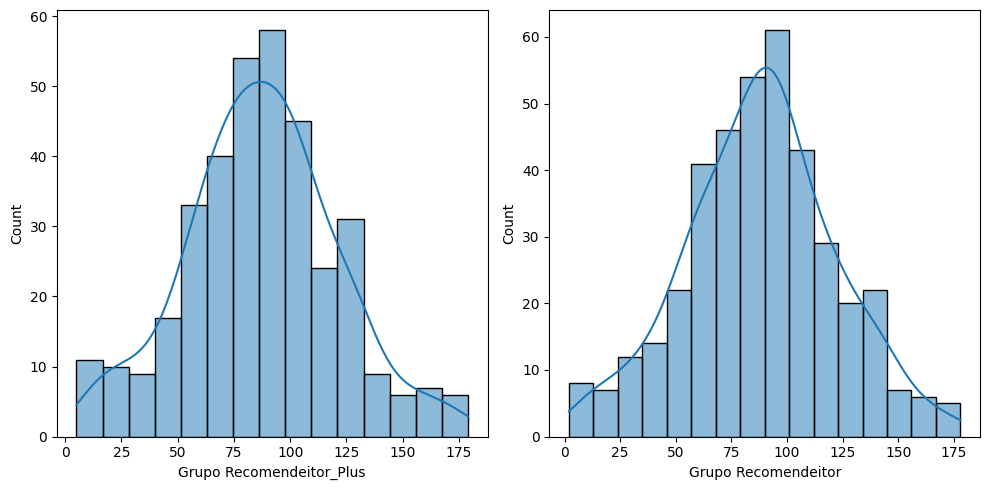

In [510]:
sf.histogramas_homocedasticidad(df_users, "sistema_usuario", "duracion_prom_sesion")

A la vista, es una distribución normal, pero podemos confirmarlo.

In [508]:
sf.iteraciones_normalidad(df_users, "sistema_usuario", "duracion_prom_sesion")

Para el grupo Recomendeitor_Plus: 5 p-valores mayores a 0.05 que siguen una distribución normal, y 0 p-valores menores a 0.05, por lo que no siguen una distribución normal.
Para el grupo Recomendeitor: 4 p-valores mayores a 0.05 que siguen una distribución normal, y 1 p-valores menores a 0.05, por lo que no siguen una distribución normal.


Dada una distribución normal, comprobamos su homocedasticidad.

In [511]:
sf.test_homocedasticidad(df_users, "sistema_usuario", "duracion_prom_sesion", "barlett")

BartlettResult(statistic=np.float64(0.0006829798759128148), pvalue=np.float64(0.9791505510216468))


In [515]:
parametricas = st.Pruebas_parametricas("sistema_usuario", "duracion_prom_sesion", df_users)
parametricas.test_t()

Estadístico t: -0.3407211332248994
Valor p: 0.733408313588688
El p-valor de la prueba es 0.73, por lo tanto, no hay evidencia de diferencias significativas entre los grupos.


### Comprobamos distribución número sesiones

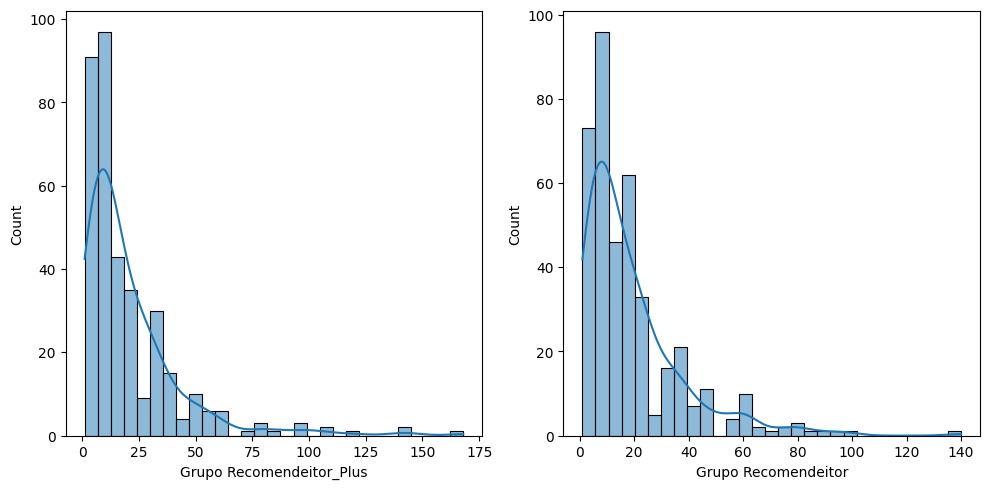

In [516]:
sf.histogramas_homocedasticidad(df_users, "sistema_usuario", "numero_sesion")

- Es evidente que no sigue una distribución normal, pero podemos comprobarlo.

In [523]:
sf.iteraciones_normalidad(df_users,"sistema_usuario","numero_sesion", 5)

Para el grupo Recomendeitor_Plus: 0 p-valores mayores a 0.05 que siguen una distribución normal, y 5 p-valores menores a 0.05, por lo que no siguen una distribución normal.
Para el grupo Recomendeitor: 0 p-valores mayores a 0.05 que siguen una distribución normal, y 5 p-valores menores a 0.05, por lo que no siguen una distribución normal.


In [520]:
grupos_sesiones = sf.crear_df_grupos(df_users, "sistema_usuario", "numero_sesion")
sf.elegir_test(grupos_sesiones)

Test Mann-Whitney
Siendo el p-valor 0.5692, no existen diferencias significativas entre los grupos.


### Comprobamos porcentaje finalizado

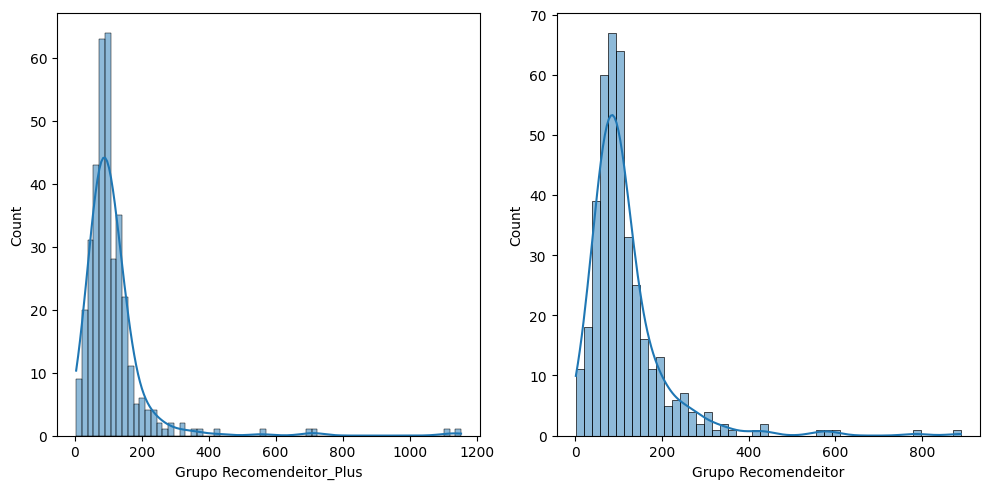

In [518]:
sf.histogramas_homocedasticidad(df_users, "sistema_usuario", "porcentaje_finalizado")

In [521]:
grupos_sesiones = sf.crear_df_grupos(df_users, "sistema_usuario", "porcentaje_finalizado")
sf.elegir_test(grupos_sesiones)

Test Mann-Whitney
Siendo el p-valor 0.636, no existen diferencias significativas entre los grupos.


### Comprobamos distribución CTR

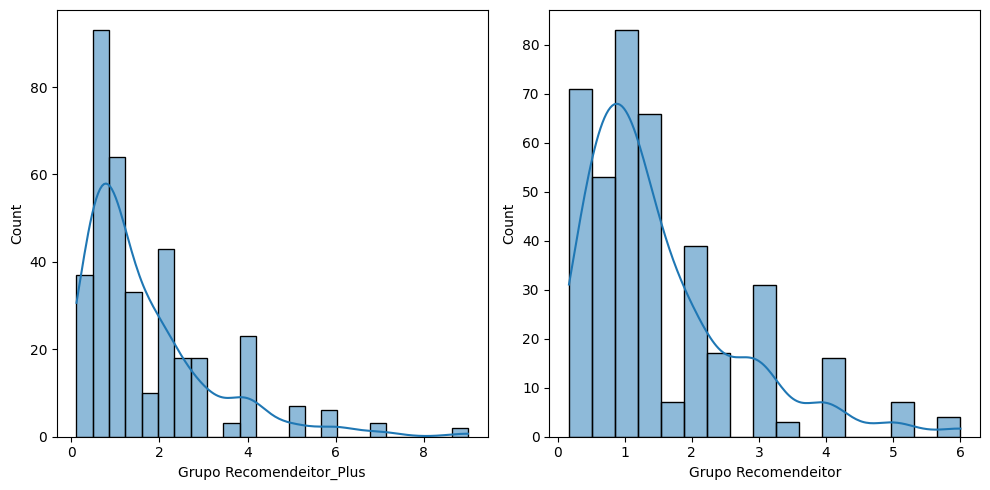

In [519]:
sf.histogramas_homocedasticidad(df_users, "sistema_usuario", "click_rate")

In [522]:
grupos_sesiones = sf.crear_df_grupos(df_users, "sistema_usuario", "click_rate")
sf.elegir_test(grupos_sesiones)

Test Mann-Whitney
Siendo el p-valor 0.8643, no existen diferencias significativas entre los grupos.


## Conclusiones